### Practical issues with A/B testing

Let's continue our example. If we have a "bank" of customers, we could fire off 3826 emails of variation A, 3826 emails of variation B, and then if B performed better, we could email the rest of our customers variation B. If A did better, or there was no clear winner, we would fall back to the default of A.

Let's say that we were interested in only targeting new signups, and that our site had 3000 people join a week. Then how long would we run our test?

A naive estimate would be that we need a total of 3826 * 2 = 7652 people. We have 3000 / 7 = 428 people per day. So maybe we should run the experiment for 7652 / 428 = 17 days?

This is fine, provided the type of people that visit our site on Monday are the same as the people that visit on Saturday. Often, websites have different volumes of traffic depending on day of the week. Employed people have different representation during the week than after it (over- or under-representation depends on the site: EW.com has a different profile than LinkedIn)

If there is a weekly cycle, you are better to round up to the nearest whole week. In this case: 7652 / 3000 = 2.55, so I would run for three weeks before drawing a conclusion. If I was looking at high cost purchases, I might see monthly patterns in my sales (as most people are paid monthly). If I did see significant monthly variation, I would push to extend the experiment to run for a month.

You should also consider (at design time) splitting your customers into clusters. Just because variationA outperforms variationB over the entire population, you can find that variationB outperfoms variationA on some subset (e.g. people on the west coast, people that log on after 5 pm, et cetra). You can choose to show different variations for different clusters. If you do this, you should know that the power calculations for sample size are the number of people that need to see each variation _per cluster_, rather than overall.

We have phrased A/B testing in terms of clicking through an email. Generally there are two types of A/B tests I have seen:
1. Engagement: do people who see variation A use the site more than people who see variation B? We are interested in optimizing the return rate.
2. Call-to-action: Each view of a variation asks a user to do something (e.g. open the email). We are interested in optimizing the success rate, which is between 0 and 1.

Our methods have all been based around "call-to-action" (see the email, then open it). Sometimes it is less clear cut, especially for "Engagement" campaigns. If you change the Duolingo Owl graphics to see if you can entice people back to learn a language more, are you going to count the number of visits that user has to the site for the next day as correlated with the campaign? The next week? The next month? Determining the answer to these questions is often a mix of looking at historical records of your users, and experimentation.

Another common use-case is looking at user-flow through a sign-up process. When do the users leave? If you show them a different process, do more of them sign up? Are you optimizing for total number of signups, or are you interested in only particular demographics. To avoid multiple testing, you should plan you experiment (including the metrics) **before** running the experiment.

A case that has less to do with web-development: you can also A/B test your **pricing and discount structures.** Uber and Lyft do this when experimenting with surge pricing and incentives for drivers. Here you have to be particularly careful, because the experiments can interfere with each other. A great example of this is on Lyft's blog:

https://eng.lyft.com/experimentation-in-a-ridesharing-marketplace-b39db027a66e

The experiment here was to **compare a passengers that didn't get charged a surge with those that do.** In an experiment where there is only one car nearby to pickup, the person with the cheaper fare will be more likely to request a ride than the person with the more expensive fare. This is what Lyft want to measure. But the effect is compounded by "blocking": whoever takes the car first stops the other person from taking the same car. In a naive A/B test or simulation where you randomly assign people to the variations, the people with the discount are expected to take $3\times$ more rides compared to those that don't. If you design the experiment differently to eliminate "blocking" (e.g. discount surges for everyone at randomly selected times) the actual effect is closer to a $1.33$ multiplier -- a huge difference!


You should aslo communicate to the devs on your team that, where possible, the same user should see the same variation each time. If Amazon is running an A/B test with green "buy" buttons, they should make sure that I see a green "buy" button until the experiment is over. Randomly seeing different elements can make people skeptical about using a site.


## What not to do: early stopping

It might be tempting to skip all the power calculations and just work "until you have reached a p-value of 0.05" and then take the winner.

**This is bad**

The p-value assumes that you do the check _once_. As a rough guide, if you do $N$ checks, if there is no difference, each time you have a probability of $\alpha$ of (falsely) claiming a winner. The probability of (correctly) claiming at no one winners in N trials is roughly
$$(1-\alpha)^N$$
I say roughly, because the trails are not independent of each other. But assuming this formula is correct, here is a table showing the effect of multiple evaluations for $\alpha = 0.05$

| Number of evaluations | Prob of correctly saying no difference | Prob of concluding difference |
|---:|---:|---:|
| 1 | 0.95 | 0.05 |
| 2 | 0.90 | 0.10 |
| 5 | 0.77 | 0.23 |
|10 | 0.59 | 0.41 |

Let's run a simulation, where at the end of the day we do a significance test until we reach the end. We will assume 200 visits a day (100 for each variation).

In [1]:
# Loads the functions we defined in previous notebook, which have
# been placed in a separate file
from abTests import variation, draw_clicks_from_n_samples, draw_p_sample_from_n_samples
from scipy.stats import norm
import numpy as np

In [2]:
def do_day(pA, pB, num_visits=100):
    cA = draw_clicks_from_n_samples(num_visits, pA, 1)[0]
    cB = draw_clicks_from_n_samples(num_visits, pB, 1)[0]
    return (variation(clicks=cA, impressions=num_visits),
            variation(clicks=cB, impressions=num_visits))

In [3]:
def cumulative_variation(var_before, var_new):
    return variation(clicks=var_before.clicks + var_new.clicks,
                     impressions=var_before.impressions + var_new.impressions)


def get_prop_from_variation(var):
    return var.clicks / var.impressions


def get_p_value_analytic(variationA, variationB):
    p_A, p_B = (variationA.clicks/variationA.impressions,
                variationB.clicks/variationB.impressions)
    p = (variationA.clicks + variationB.clicks)/(variationA.impressions + variationB.impressions)
    variance = p*(1-p)/variationA.impressions + p*(1-p)/variationB.impressions

    abs_z = abs(p_A - p_B)/np.sqrt(variance)

    p_value = 2*(1-norm.cdf(abs_z))
    return p_value


def run_test_with_peeking(n_days, pA, pB, alpha=0.05):
    cumulative_var_A = variation(clicks=0, impressions=0)
    cumulative_var_B = variation(clicks=0, impressions=0)
    for day in range(n_days):
        varA, varB = do_day(pA, pB)
        cumulative_var_A = cumulative_variation(cumulative_var_A, varA)
        cumulative_var_B = cumulative_variation(cumulative_var_B, varB)
        p_value = get_p_value_analytic(cumulative_var_A, cumulative_var_B)
        if p_value < alpha:
            if get_prop_from_variation(cumulative_var_A) > get_prop_from_variation(cumulative_var_B):
                winner = 'A'
            else:
                winner = 'B'
            return {
                'day': day,
                'winner': winner,
                'p': p_value
            }
    return {
        'day': day,
        'winner': None,
        'p': p_value
    }

In [4]:
# run a single time with pA = pB = 5% over 30 days
run_test_with_peeking(30, 0.05, 0.05)

{'day': 29, 'winner': None, 'p': 0.19110950927817694}

In [5]:
# Let's simulate 1000 experiments. How often are they called?
all_exp = [run_test_with_peeking(30, 0.05, 0.05) for _ in range(1000)]

In [6]:
# How many had the correct answer, None, as the winner?
num_type_1_errors = len([e for e in all_exp if e['winner'] is not None])
frac_type_1_errors = num_type_1_errors/len(all_exp)
print("With peeking and alpha=0.05, we had a type 1 error rate of {}".format(frac_type_1_errors))

With peeking and alpha=0.05, we had a type 1 error rate of 0.294


[20, 0, 5, 12, 0, 0, 9, 0, 9, 11, 3, 5, 19, 10, 25, 9, 15, 22, 2, 2, 2, 16, 1, 1, 14, 14, 0, 7, 3, 1, 1, 0, 12, 1, 6, 16, 5, 2, 1, 1, 3, 6, 26, 7, 8, 11, 21, 24, 0, 1, 8, 2, 1, 1, 4, 2, 18, 0, 1, 16, 18, 9, 6, 21, 0, 1, 4, 15, 3, 0, 2, 22, 0, 11, 26, 13, 0, 0, 3, 4, 0, 2, 2, 11, 15, 2, 13, 5, 0, 2, 4, 2, 29, 9, 29, 16, 13, 4, 19, 16, 15, 29, 7, 10, 17, 14, 11, 5, 0, 2, 23, 0, 7, 2, 6, 16, 1, 0, 6, 16, 0, 9, 8, 9, 1, 4, 29, 1, 6, 2, 1, 21, 4, 9, 16, 2, 9, 5, 4, 3, 0, 0, 3, 13, 11, 9, 1, 16, 16, 4, 5, 3, 4, 18, 2, 20, 2, 23, 6, 20, 8, 10, 4, 0, 7, 3, 0, 1, 5, 1, 3, 0, 25, 4, 19, 0, 7, 7, 6, 25, 14, 0, 11, 8, 7, 2, 27, 0, 0, 10, 7, 21, 17, 7, 11, 2, 2, 6, 4, 5, 16, 3, 4, 5, 11, 1, 0, 2, 2, 1, 0, 3, 0, 0, 6, 21, 13, 10, 23, 7, 8, 6, 12, 7, 5, 0, 17, 0, 1, 1, 2, 10, 2, 2, 2, 6, 1, 1, 0, 23, 19, 10, 0, 28, 25, 1, 14, 7, 0, 0, 1, 4, 15, 6, 3, 11, 1, 7, 0, 4, 2, 0, 1, 4, 1, 8, 0, 16, 0, 0, 1, 8, 18, 19, 0, 2, 12, 4, 0, 3, 18, 16, 0, 17, 0, 29, 13, 17, 2, 3, 3, 2, 0, 9]


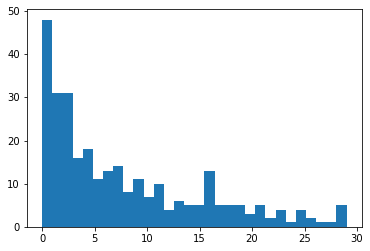

In [15]:
import matplotlib.pyplot as plt


%matplotlib inline

# How long did it take to reach the incorrect conclusion?
num_days = [e['day'] for e in all_exp if e['winner'] is not None]
print(num_days)
plt.hist(num_days, bins=30);

# Alternative to early stopping: multi-armed bandit

The multi-armed bandit approach to the same problem is modelling off the following: each variation is like a slot machine. You have a certain number of customers to "spend", and you might get a reward if they win. You have to decide how to "spend your customers" (i.e. how to split them amongst the different variations)

The basic idea is simple:
1. Play a "few" rounds, and see how well each variation does (exploratory phase)
2. When a user arrives, assign her randomly to a variation. Variations that are doing better (i.e. have higher conversion rates) have a higher probability of being picked.  Record what the new user does (success vs fail). Update the probabilities to reflect current conversion rates. (exploitation phase).

The idea is that variations that do well will be selected more often, and variations that do poorly will "die out". There are a couple of different ways of implementing step 2 (mapping from success rates to chance of picking a variation).

Two common methods are __epsilon greedy__ and __thompson sampling__

## Epsilon greedy (technically epsilon-first greedy)

Basic setup:

You will need to pick $N$ (the number of users you use to evaluate the variations initially), and $\epsilon$ (the probability of exploring).

1. Use the first N users (you choose N) to determine the success rate of each variation
2. For each user, pick a number between 0 and 1. If the number is less than $\epsilon$, randomly choose a variation. Otherwise, just send the user to the current best variation.

In [8]:
def is_success(prob):
    return np.random.rand() < prob


def epsilon_greedy_sim(N0, epsilon, actual_probs, num_trials):
    """
    N0: integer, number of users to send to each variation
    epsilon: float between 0 and 1. Probability of exploring new variation
    actual_probs: a list of probabilities of success for each variation
    num_trials: num of users total to use after the initialization

    returns a list of success rates found by the simulation
    """
    current = [variation(clicks=sum([is_success(p) for _ in range(N0)]), impressions=N0)
                     for p in actual_probs]
    for _ in range(num_trials):
        if is_success(epsilon):
            # randomly pick a variation
            var_to_do = np.random.randint(0, len(actual_probs) - 1)
        else:
            var_to_do = np.argmax(np.array([get_prop_from_variation(v) for v in current]))
        current[var_to_do] = cumulative_variation(current[var_to_do],
                                                  variation(clicks=is_success(actual_probs[var_to_do]), impressions=1))

    return current

In [9]:
# here is an example using 3 variations with
# 4% conversion rate, 3% and 2% respectively
np.random.seed(42)
epsilon_greedy_sim(100, 0.1, [0.04, 0.03, 0.02], 10000)

[variation(clicks=417, impressions=9577),
 variation(clicks=14, impressions=623),
 variation(clicks=3, impressions=100)]

Note this identified mostly variation A, which is what we want. If the variations are close, a sub-par variation can take the lead early, and then keeps it:

In [10]:
# np.random.seed(60)
epsilon_greedy_sim(100, 0.1, [0.04, 0.03, 0.02], 10000)  # burn a random seed
epsilon_greedy_sim(100, 0.1, [0.04, 0.03, 0.02], 10000)

[variation(clicks=72, impressions=1775),
 variation(clicks=257, impressions=8425),
 variation(clicks=1, impressions=100)]

The ways to avoid this:
- Increase $N0$: require more sampling initially, so it is harder for a bad variation to get a head start
- Increase $\epsilon$: Make more random pulls. This gives good variations more of a chance to catch up

Note that both of these techniques require me to give up making the current best choice. The big difference is $\epsilon$ is "forever" -- if I have $\epsilon=0.15$ I am deciding that I am always experimenting with 15% of my data. 

If $\epsilon$ is small, we cannot catch up from a suboptimal variation that started with a string of good luck.

If two variations have similar conversion rates, then it is easier for the suboptimal ones to "win". The motivation of using the bandit algorithms is you don't "waste" as much time finding the best variation, and even if you pick a suboptimal variation it is likely to be a better suboptimal variation.

#### Pitfall

If you have weekly variation in your data, you don't want to make your initial data collection less than a week. If a traditional A/B test would work in that time frame, then you should do that.

## Thompson sampling

Basic idea:
1. Start every variation as having a success probability drawn from p_i ~ Beta(1,1) i.e. uniform
2. When a new user comes in, draw a random probability of success from each Beta(S_i+1, F_i+1) distribution, where $S_i$ is the number of successes in variation $i$, and $F_i$ is the number of failures in variation $i$.
3. Assign the user to whichever variation had the largest probability drawn in step 2.


In [11]:
from scipy.stats import beta


beta.rvs(a=1, b=1)

0.1995105571583218

In [12]:
def thompson_sim(actual_probs, num_trials):
    """
    actual_probs: a list of probabilities of success for each variation
    num_trials: num of users total to use after the initialization

    returns a list of variations about what happened in the experiments
    """
    current = [(1, 1) for _ in actual_probs]
    for _ in range(num_trials):
        prob_draw = np.array([beta.rvs(Alpha, Beta) for Alpha, Beta in current])
        to_use = np.argmax(prob_draw)
        trial_success = is_success(actual_probs[to_use])
        current[to_use] = (current[to_use][0] + trial_success, current[to_use][1] + (1-trial_success))

    return [variation(clicks=Alpha, impressions=Alpha + Beta) for Alpha, Beta in current]

In [13]:
np.random.seed(42)
thompson_sim([0.04, 0.03, 0.02], 10000)

[variation(clicks=362, impressions=9209),
 variation(clicks=7, impressions=385),
 variation(clicks=8, impressions=412)]

# Pros and cons

| Property | A/B testing (p-value)| MAB: Epsilon | MAB: Thompson |
|---| --- | --- | --- |
| Fixed time | Yes | No | No|
| Continual costs | No (experiment ends) | Yes | Yes |
| Parameters | $\alpha$, power, time | $N_0$, $\epsilon$, time| time |
| Early Leaders bias results | No | Yes, strongly | Yes, but only mild |
| Adaptive | No | Yes | Yes |
| _Natural_ generalizes to many variations | No(\*) | Yes | Yes |
| Makes Type I guarantees | Yes | No | No |

# Review

* **DO** a power calculation ahead of time. Make sure you have some idea of what the experiment "costs" to run, and how certain you need to be.
* **DO** an analysis of whether a standard A/B test makes sense, or if you should use a MAB strategy. 
    * Standard A/B tests are usually for cases where you have an established standard or you are more risk adverse. 
    * MAB is useful for getting through many iterations quickly, and the cost of making a suboptimal decision isn't critial.
    * See table above for clarity
* **DON'T** stop mid-cycle. Identify significant periods for your problem, and do a whole number of these cycles.
* **DO** break customers into segments as appropriate.
* **DON'T** rely on this checklist -- go back and **read** the section _Practical issues with A/B testing_. Experimental design is hard and subtle, and doing the wrong design can get you "the right answer to the wrong question" rendering your analysis useless. This is something to take your time on!
* **DO** re-read the _Practical issues with A/B testing_ section!